<a href="https://colab.research.google.com/github/Nicolas-Noir/AA2/blob/main/TP1/AA2_TP1_ej1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
students_csv = "https://raw.github.com/Nicolas-Noir/AA2/main/TP1/Student_Performance.csv"
students = requests.get(students_csv)

with open("students_data.csv", "wb") as file:
    file.write(students.content)

students_data = pd.read_csv("students_data.csv")

In [ ]:
students_data.head(3)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0


In [ ]:
students_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


## Separamos el dataset en train, test y validacion

In [ ]:
x_data = students_data.drop("Performance Index", axis=1)
y_data = students_data["Performance Index"]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data , test_size=0.2, random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=321)
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((6000, 5), (2000, 5), (2000, 5), (6000,), (2000,), (2000,))

## limpieza de datos

In [ ]:
def yes_no_to_bool(df):
  df = df.map(lambda x: x.strip().lower() if isinstance(x, str) else x)
  df.replace({"yes": 1, "no": 0}, inplace=True)
  return df

In [ ]:
x_train = x_train.apply(yes_no_to_bool)
x_test = x_test.apply(yes_no_to_bool)
x_val = x_val.apply(yes_no_to_bool)

<ipython-input-6-1e55e3ca9056>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"yes": 1, "no": 0}, inplace=True)


## matriz de correlacion

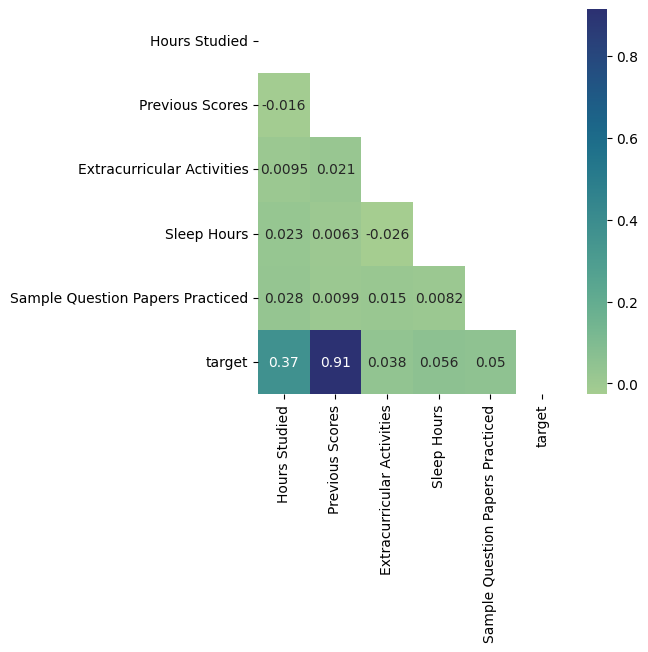

In [ ]:
x_comb = x_train.copy()
x_comb["target"] = y_train

plt.figure(figsize=(5, 5))
matrix = np.triu(x_comb.corr())
sns.heatmap(x_comb.corr(), cmap=sns.color_palette("crest", as_cmap=True), annot=True, mask=matrix)
plt.show()

In [ ]:
x_train.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.994667,69.408167,0.497667,6.535167,4.568667
std,2.598993,17.377981,0.500036,1.702130,2.863620
min,1.000000,40.000000,0.000000,4.000000,0.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000


In [ ]:
scaler = MinMaxScaler()
scaler.fit(x_train)

columnas = x_train.columns

x_train = pd.DataFrame(scaler.transform(x_train), columns=columnas, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=columnas, index=x_test.index)
x_val = pd.DataFrame(scaler.transform(x_val), columns=columnas, index=x_val.index)

In [ ]:
early_stopping = EarlyStopping( monitor="val_loss", patience=10, verbose=0, mode="min", restore_best_weights=True)

reduce_lr = ReduceLROnPlateau( monitor="loss", factor=0.5, patience=8, verbose=1, min_delta=1e-4, mode="min")

model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit( x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113 (452.00 B)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3331.5847 - mae: 54.3489 - val_loss: 3297.9072 - val_mae: 54.1826 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3186.5359 - mae: 53.2135 - val_loss: 3110.4504 - val_mae: 52.4876 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2996.4656 - mae: 51.3479 - val_loss: 2858.2649 - val_mae: 50.1183 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2721.9565 - mae: 48.7025 - val_loss: 2541.0710 - val_mae: 46.9727 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2416.3687 - mae: 45.5785 - val_loss: 2190.7493 - val_mae: 43.2333 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2052.1138 - mae: 41.6542 - val_loss: 1834.0294 - val_mae: 39.0687 - learning_rate: 0.0010
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1730.6049 - mae: 37.6924 - val_loss: 1492.0945 

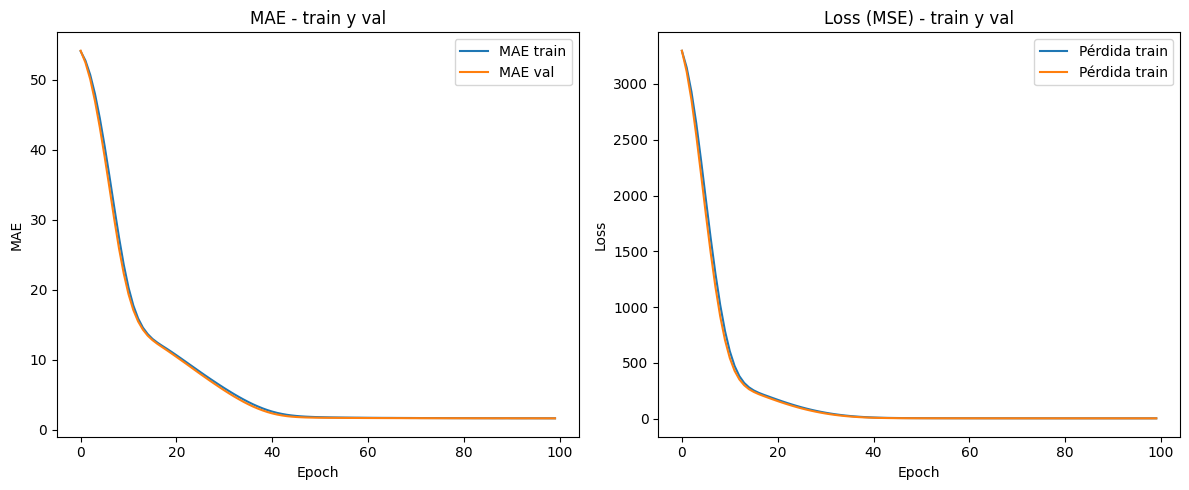

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='MAE train')
plt.plot(epochs_range, val_mae, label='MAE val')
plt.legend(loc='upper right')
plt.title('MAE - train y val')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida train')
plt.plot(epochs_range, val_loss, label='Pérdida train')
plt.legend(loc='upper right')
plt.title('Loss (MSE) - train y val')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


##Optimizado con optuna

In [ ]:
!pip install optuna
import optuna

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    units_1 = trial.suggest_int("units_1", 64, 256, step=32)
    units_2 = trial.suggest_int("units_2", 32, 128, step=32)

    model = Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(units_1, activation='relu'),
        Dropout(dropout_rate),
        Dense(units_2, activation='relu'),
        Dense(units_2, activation='relu'),
        Dense(units_2, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error', metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
    checkpoint = ModelCheckpoint(
        filepath=f"model-trial{trial.number}-val_loss{{val_loss:.3f}}.keras",
        monitor="val_loss",
        save_best_only=True,
        mode="min",
        verbose=0
    )
    reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=8, verbose=0, min_delta=1e-4, mode="min")

    history = model.fit(
        x_tr, y_tr,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=0
    )

    return min(history.history["val_loss"])

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print(" Mejores hiperparámetros encontrados:")
print(study.best_params)